# Estimation on real data using MSM

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from Model import RetirementClass
import figs
import SimulatedMinimumDistance as SMD

# Global modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data

In [126]:
data = pd.read_excel('SASdata/couple_moments.xlsx')
Nobs = np.median(data['obs'])
mom_data = data['mom'].to_numpy()
cov = pd.read_excel('SASdata/Cov.xlsx')
weight = 1/np.sqrt(np.diag(cov))
W = np.eye(len(weight))*weight
Omega = cov*Nobs

### Set up estimation

In [6]:
Couple = RetirementClass(couple=True, simN=int(1e5), simT=68-53+1)
Couple.solve()
Couple.simulate()

In [128]:
# function to generate moments
def mom_fun(Couple):
    return SMD.MomFunCouple_agg(Couple)

In [129]:
#est_par = ["alpha_0_male", "alpha_0_female", "alpha_1", "sigma_eta", "phi_0_male"]
est_par = ["alpha_0_male", "alpha_0_female", "sigma_eta" "phi_0_male"]
est_par_tex = ['$\alpha_0^m$', '$\alpha_0^f$', '$\sigma$', '$\phi$']

fixed_par = ('R', 'rho', 'beta', 'gamma', 
             'priv_pension_male', 'priv_pension_female', 'g_adjust', 'pi_adjust_m', 'pi_adjust_f')
fixed_par_tex = (r'$R$', r'$\rho$', r'$\beta$', r'$\gamma$', 
                 r'$PPW^m$', r'$PPW^f$', r'$g$', r'$\pi_m$', r'$\pi_f$')

smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun)
smd.est_par = est_par

### Estimate

In [75]:
theta0 = SMD.start(10,bounds=[(0,),(0,1),(0.2,0.8),(0,2)])

In [92]:
theta0

[[0.307, 0.265, 0.166], [0.124, 0.03, 0.333], [0.182, 0.037, 1.751]]

In [130]:
smd.MultiStart(theta0,W)
theta = smd.est

In [ ]:
smd.std_error(theta,Omega,W,Nobs=Nobs,Nsim=Couple.par.simN*5/Nobs)
std_error = smd.std
smd.obj_fun(theta,W) # set theta as parameters
print('Parameters:', np.round(theta,3))
print('Std error :', np.round(std_error,3))
SMD.save_est(est_par,theta,name='baseline') # save parameters

### Model fit

In [149]:
def model_fit_marg(Couple,ma):
    moments = pd.read_excel('SASdata/couple_moments_total.xlsx')
    if ma == 0:
        mom = moments['Mom_marg_kvinde'].dropna().to_numpy()
    elif ma == 1:
        mom = moments['Mom_marg_mand'].dropna().to_numpy()
    data = {'y': [mom], 'x': np.arange(58,69), 'label': ['Data'], 'color': 'k',
            'linestyle': ['None'], 'marker': 'o'}    
    pred = figs.retirement_probs_c(Couple,ma=ma)
    return [data,pred]

def model_fit_joint(Couple,save=True):
    moments = pd.read_excel('SASdata/couple_moments_total.xlsx')['Mom_joint'].to_numpy()
    pred = mom_fun(Couple)[-15:] # last 15 elements
    
    # plot
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)    
    plt.bar(np.arange(-7,8),moments,label='Data')
    plt.plot(np.arange(-7,8),pred,'k--',label='Predicted',linewidth=3)
    ax.legend(fontsize=12)
    ax.set_xlabel('Difference in year of retirement (year_w-year_h)', fontsize=15)
    ax.set_ylabel('Share', fontsize=15)    
    ax.tick_params(axis='both', which='major', labelsize=15)        
    fig.tight_layout()
    if save:
        return fig

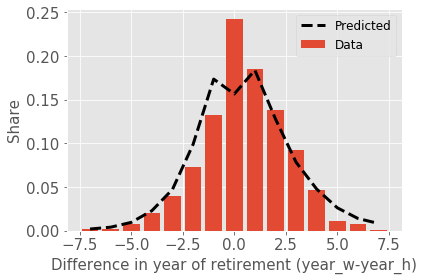

In [150]:
model_fit_joint(Couple).savefig('figs/ModelFit/Joint')

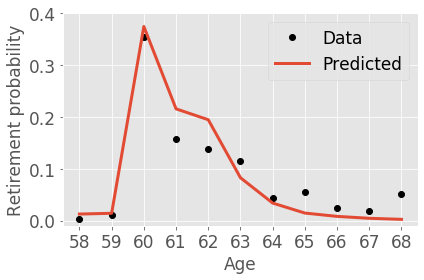

In [151]:
figs.MyPlot(model_fit_marg(Couple,0),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/MargWomen.png')

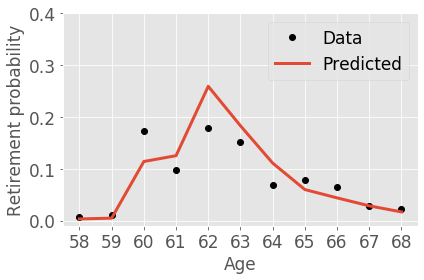

In [152]:
figs.MyPlot(model_fit_marg(Couple,1),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/MargMen.png')

### Sensitivity to first step calibrated parameters

In [ ]:
smd.recompute=True
smd.sensitivity(theta,weight,fixed_par)
figs.sens_fig_tab(smd.sens2[:,:5],smd.sens2e[:,:5],theta,est_par_tex,fixed_par_tex[:5]).savefig('figs/Sens/CouplePref.png')
figs.sens_fig_tab(smd.sens2[:,5:],smd.sens2e[:,5:],theta,est_par_tex,fixed_par_tex[5:]).savefig('figs/Sens/CoupleCali.png')

### Estimate (phi=0)

In [ ]:
Couple.par.phi_0_male = 0
Couple.par.phi_0_female = 0
Couple.par.phi_1 = 0
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun)
smd.est_par = ["alpha_0_male", "alpha_0_female", "sigma_eta"]

In [ ]:
theta0 = SMD.start(10,bounds=[(0,1),(0,1),(0.2,0.8)])

In [ ]:
smd.MultiStart(theta0,W)
theta = smd.est

In [ ]:
smd.std_error(theta,Omega,W,Nobs=Nobs,Nsim=Couple.par.simN*5/Nobs)
std_error = smd.std
print('Parameters:', np.round(theta,3))
print('Std error :', np.round(std_error,3))
SMD.save_est(est_par,theta,name='phi0',couple=True) # save parameters

In [ ]:
model_fit_joint(Couple).savefig('figs/ModelFit/Joint_phi0')

In [ ]:
figs.MyPlot(model_fit(Couple,0),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/MargWomen_phi0.png')

In [ ]:
figs.MyPlot(model_fit(Couple,1),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/MargMen_phi0.png')

### Shut down financial incentives

In [ ]:
Couple.par.couple_finance=False
Couple.solve(recompute=True)

In [ ]:
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun)
smd.est_par = est_par[0:4]

In [ ]:
smd.MultiStart(theta0,W)
theta = smd.est

In [ ]:
smd.std_error(theta,Omega,W,Nobs=Nobs,Nsim=Couple.par.simN/Nobs)
std_error = smd.std
print('Parameters:', np.round(theta,3))
print('Std error :', np.round(std_error,3))
SMD.save_est(est_par,theta,name='phi0_financial0',couple=True) # save parameters

In [ ]:
model_fit_joint(Couple).savefig('figs/ModelFit/Joint_phi0_financial0')

In [ ]:
figs.MyPlot(model_fit(Couple,0),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/MargWomen_phi0_financial0.png')

In [ ]:
figs.MyPlot(model_fit(Couple,1),ylim=[-0.01,0.4],linewidth=3).savefig('figs/ModelFit/MargMen_phi0_financial0.png')